In [1]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

import ray
from ray import tune, train
from ray.tune.search.flaml import BlendSearch
from ray.tune.search import ConcurrencyLimiter
from ray.air.integrations.keras import ReportCheckpointCallback

import tensorflow as tf
from tensorflow.keras.datasets import cifar100

2023-12-17 08:39:33.838760: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 08:39:33.881995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 08:39:33.882029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 08:39:33.882063: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 08:39:33.890256: I tensorflow/core/platform/cpu_feature_g

In [2]:
(x, y), (x_test, y_test) = cifar100.load_data(label_mode="coarse")
print(x.shape, y.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
y = y.flatten()
y_test = y_test.flatten()

## Describe data

In [4]:
classes_df = pd.DataFrame(data=y, columns=["label"])
classes_df["label"] = classes_df["label"].astype(str)
classes_df.describe()

label
count   50000
unique     20
top        11
freq     2500

Text(0.5, 1.0, 'The number of images for each class')

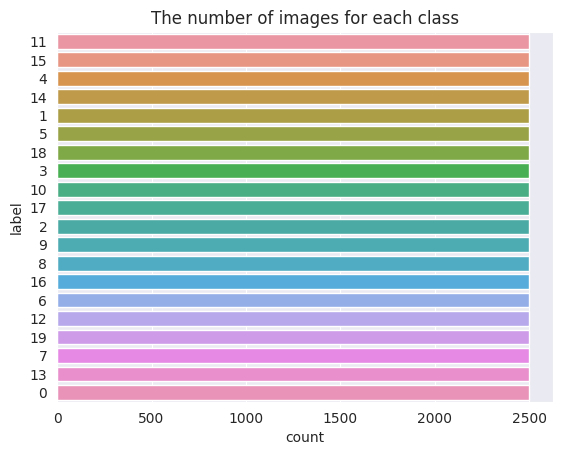

In [5]:
sns.countplot(y=classes_df["label"]).set_title("The number of images for each class")

In [6]:
classes_df.value_counts()

label
0        2500
1        2500
8        2500
7        2500
6        2500
5        2500
4        2500
3        2500
2        2500
19       2500
18       2500
17       2500
16       2500
15       2500
14       2500
13       2500
12       2500
11       2500
10       2500
9        2500
Name: count, dtype: int64

We have 20 and we can not show it in one board. So we have decided to split it into 4 parts and show in 4 cells outputs. This function takes the list of unique classes that should be shown and show a board with unique class per row and 5 images per class in a row.

In [7]:
def show_class_photos(unique_classes, photos_to_show_per_class=5):
    rows = len(unique_classes) 

    fig = plt.figure(constrained_layout=True)
    row_subfigs = fig.subfigures(nrows=rows, ncols=1)

    for every_row_subfigure, every_class in zip(row_subfigs, unique_classes):
        every_row_subfigure.suptitle(every_class)
        class_positions = np.where(y==every_class)[0]
        random_images_positions = np.random.choice(class_positions, size=photos_to_show_per_class)
        chosen_images = x[random_images_positions, :]
        column_subplots = every_row_subfigure.subplots(nrows=1, ncols=photos_to_show_per_class)
        for every_column_subplot, every_image_array in zip(column_subplots, chosen_images):
            every_column_subplot.axis('off')
            every_column_subplot.imshow(every_image_array, cmap="gray")

In [4]:
unique_classes = np.unique(y)
unique_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

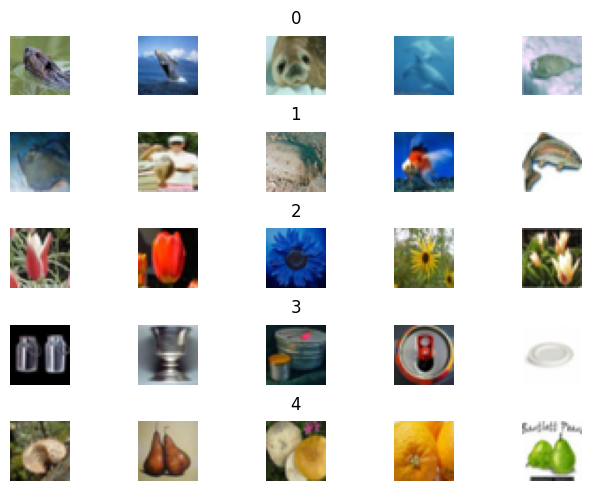

In [9]:
show_class_photos(unique_classes[:5])

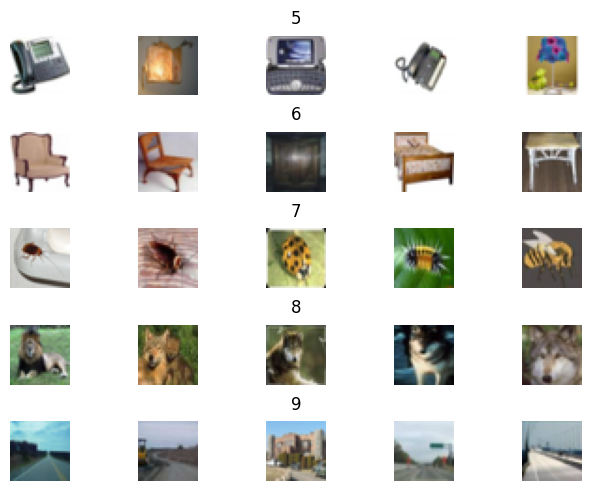

In [10]:
show_class_photos(unique_classes[5:10])

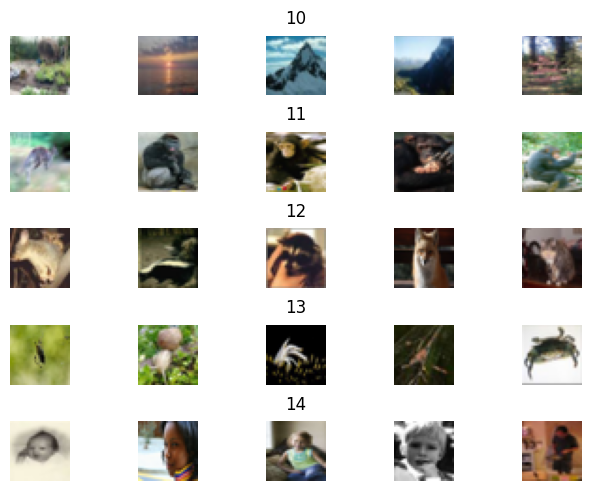

In [11]:
show_class_photos(unique_classes[10:15])

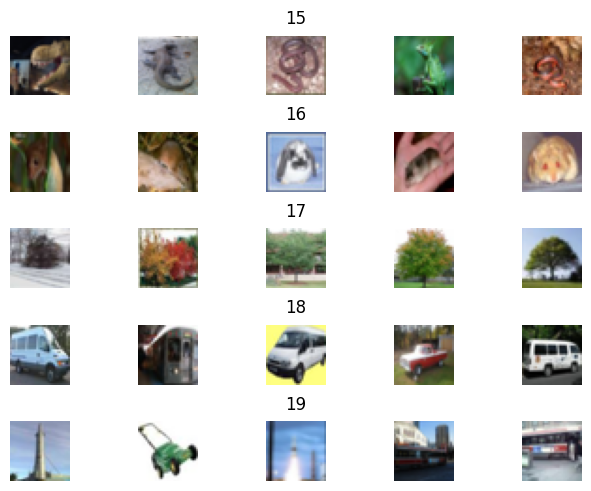

In [12]:
show_class_photos(unique_classes[15:])

In [9]:
pixels_stats = pd.Series(
    data=[
        np.mean(x),
        np.min(x),
        np.max(x),
        np.var(x),
        np.std(x),
        np.ptp(x)
    ],
    index=["mean", "mean", "max", "var", "std_dev", "range"]
)
pixels_stats

mean        121.936059
mean          0.000000
max         255.000000
var        4677.049383
std_dev      68.388957
range       255.000000
dtype: float64

## Preprocess

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(40000, 32, 32, 3) (40000,) (10000, 32, 32, 3) (10000,)


In [5]:
binarizer = LabelBinarizer()
y_train_one_hot = binarizer.fit_transform(y_train)
y_val_one_hot = binarizer.transform(y_val)
print(y_train_one_hot.shape, y_val_one_hot.shape)

(40000, 20) (10000, 20)


In [6]:
x_train = x_train.astype(np.float64)
x_val = x_val.astype(np.float64)

In [7]:
x_train /= 255.0
x_val /= 255.0

## Train naive

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(unique_classes.shape[0], activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

2023-12-10 14:43:39.873152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 14:43:39.873957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-10 14:43:39.874701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train_one_hot,
    validation_data=(x_val, y_val_one_hot),
    epochs=40, batch_size=64,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop_callback]
)

2023-12-10 14:43:43.208885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-10 14:43:43.883997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-12-10 14:43:45.142320: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa3c84df70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 14:43:45.142358: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-10 14:43:45.142364: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-10 14:43:45.142369: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): 

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="Accuracy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="Validation Accuracy"),
    secondary_y=False,
)

fig.update_layout(
    title_text="Accuracy for Train and Validation sets"
)

fig.update_xaxes(title_text="Epochs")

fig.update_yaxes(title_text="Accuracy", secondary_y=False)

fig.show()

## Architecture

In [22]:
ray.init(ignore_reinit_error=True, log_to_driver=False, logging_level="ERROR")

RayContext(dashboard_url='127.0.0.1:8265', python_version='3.11.0', ray_version='2.8.1', ray_commit='82a8df138fe7fcc5c42536ebf26e8c3665704fee', protocol_version=None)

In [8]:
def train_architectures(config):
    batch_size = 512
    epochs = 30

    # define data
    (x, y), (_, _) = cifar100.load_data(label_mode="coarse")
    y = y.flatten()
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

    binarizer = LabelBinarizer()
    y_train_one_hot = binarizer.fit_transform(y_train)
    y_val_one_hot = binarizer.transform(y_val)
    x_train = x_train.astype(np.float64)
    x_val = x_val.astype(np.float64)
    x_train /= 255.0
    x_val /= 255.0

    conv_layers = []
    for index, (filters, kernels) in enumerate(list(zip(config["filters"], config["kernels"]))):
        if index == 0:
            conv_layers.append(
                tf.keras.layers.Conv2D(filters, (kernels, kernels), padding="same", activation='relu', input_shape=x_train.shape[1:]))
            continue

        conv_layers.append(
            tf.keras.layers.Conv2D(filters, (kernels, kernels), padding="same", activation='relu'))

        if index % 2 == 1 and index + 1 != config["layers"]:
            conv_layers.append(tf.keras.layers.MaxPooling2D())

    conv_layers.append(tf.keras.layers.MaxPooling2D())
    
    model = tf.keras.Sequential([
        *conv_layers,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(20, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    model.fit(
        x_train, y_train_one_hot,
        validation_data=(x_val, y_val_one_hot),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[
            ReportCheckpointCallback(metrics={"Accuracy": "val_accuracy"}),
            early_stop_callback
        ]
    )

We have three params: number of layers, number of filters in each layer, size of the conv kernel for each layer. And it does not mean that last 2 params will be same for each layer. This tuner searches for the highest accuracy for the model with $1-4$ possible layers, each layer can have $8/16/32/64$ filters with $2/3/4$ conv sizes for each layer. We also would like to put pooling layers after each two conv layers and at the end of the layers list.

In [9]:
def tune_architectures():
    algo = BlendSearch()
    algo = ConcurrencyLimiter(algo, max_concurrent=3)
    tuner = tune.Tuner(
        tune.with_resources(train_architectures, resources={"cpu": 2, "gpu": 1}),
        tune_config=tune.TuneConfig(
            metric="Accuracy",
            mode="max",
            num_samples=3000,
            search_alg=algo
        ),
        run_config=train.RunConfig(
            local_dir="/ray",
        ),
        param_space={
            "layers": tune.choice([1, 2, 3, 4]),
            "filters": tune.sample_from(lambda spec: np.random.choice(np.array([8, 16, 32, 64]), size=spec.config.layers)),
            "kernels": tune.sample_from(lambda spec: np.random.choice(np.array([2, 3, 4]), size=spec.config.layers))
        },
    )
    results = tuner.fit()
    df = results.get_dataframe(filter_metric="Accuracy", filter_mode="max")[["Accuracy", "config/layers", "config/filters", "config/kernels"]].sort_values(by=["Accuracy"], ascending=False)
    df.to_csv("architectures.csv")

In [ ]:
tune_architectures()

In [21]:
ray.shutdown()

In [15]:
pd.read_csv("architectures.csv").groupby(["config/layers", "config/filters", "config/kernels"]).mean().sort_values(by=["Accuracy"], ascending=False)[["Accuracy"]]

Accuracy
config/layers config/filters config/kernels          
3             [16 32 32]     [2 2 3]         0.451600
              [16 16 32]     [2 4 2]         0.446200
              [32 32 16]     [2 3 2]         0.445700
              [ 8 32 64]     [2 2 2]         0.445667
              [ 8 64 32]     [2 3 2]         0.444950
...                                               ...
              [64 16 64]     [2 2 3]         0.049500
              [64  8 64]     [3 3 4]         0.049500
              [16 64 32]     [4 4 3]         0.049400
              [64 16 64]     [3 3 2]         0.049400
                             [4 4 4]         0.048700

[1590 rows x 1 columns]

So the layer with the architecture:
$$
Conv2D(16, 2) \\
Conv2D(32, 2) \\
MaxPooling() \\
Conv2D(32, 3) \\
MaxPooling() \\
Dense(128) \\
Dense(20)
$$

got the most accuracy $0.395567$.

## Legularization

Here we will tune accuracy of the model base on the regularization.

In [20]:
regularizers = [tf.keras.regularizers.L1, tf.keras.regularizers.L2, tf.keras.regularizers.L1L2]
l1 = np.random.uniform(0, 0.01, 10)
l2 = np.random.uniform(0, 0.01, 10)
reg_space = list(product(regularizers, l1, l2))
reg_space

[(keras.src.regularizers.L1, 0.007274723404767682, 0.0035312996854932432),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.001841900260747561),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.002641457124432616),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0023009043974457155),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.008027297745141526),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0072391017671869055),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0032260596223700577),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0063902192539287426),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0034403496293257353),
 (keras.src.regularizers.L1, 0.007274723404767682, 0.0029397120170585023),
 (keras.src.regularizers.L1, 0.009026088738368385, 0.0035312996854932432),
 (keras.src.regularizers.L1, 0.009026088738368385, 0.001841900260747561),
 (keras.src.regularizers.L1, 0.009026088738368385, 0.002641457124432616),
 (keras.src.regularizers.L1, 0

Here is the search space for regularizers for each layer. We will randomly choose 10 options for each layer.

In [21]:
def gen_random_regularizers(sp, size):
    chosen_regularizers_idx = np.random.choice(len(sp), size=size)
    return list(map(lambda x: reg_space[x], chosen_regularizers_idx))

In [22]:
layer1_space = gen_random_regularizers(reg_space, 10)
layer1_space

[(keras.src.regularizers.L2, 0.005356830021182149, 0.001841900260747561),
 (keras.src.regularizers.L2, 0.007276278875039153, 0.0035312996854932432),
 (keras.src.regularizers.L2, 0.007177214393529471, 0.0023009043974457155),
 (keras.src.regularizers.L1L2, 0.009923495046127889, 0.002641457124432616),
 (keras.src.regularizers.L1, 0.007177214393529471, 0.0063902192539287426),
 (keras.src.regularizers.L2, 0.007274723404767682, 0.001841900260747561),
 (keras.src.regularizers.L2, 0.009026088738368385, 0.0035312996854932432),
 (keras.src.regularizers.L2, 0.007274723404767682, 0.0063902192539287426),
 (keras.src.regularizers.L2, 0.001506384044476199, 0.0063902192539287426),
 (keras.src.regularizers.L2, 0.007177214393529471, 0.002641457124432616)]

In [17]:
layer2_space = gen_random_regularizers(reg_space, 5)
layer2_space

[(keras.src.regularizers.L1, 0.0012626046781725442, 0.0010501290945444065),
 (keras.src.regularizers.L2, 0.00937587079970709, 0.0020023782734856855),
 (keras.src.regularizers.L2, 0.0038798367233365627, 0.00797707829991205),
 (keras.src.regularizers.L1L2, 0.0012626046781725442, 0.003823396533963741),
 (keras.src.regularizers.L2, 0.006758259886511088, 0.0020023782734856855)]

In [19]:
layer3_space = gen_random_regularizers(reg_space, 5)
layer3_space

[(keras.src.regularizers.L2, 0.0063883680563089264, 0.00797707829991205),
 (keras.src.regularizers.L1L2, 0.00937587079970709, 0.00797707829991205),
 (keras.src.regularizers.L1, 0.0012626046781725442, 0.003823396533963741),
 (keras.src.regularizers.L1L2, 0.00937587079970709, 0.0020023782734856855),
 (keras.src.regularizers.L2, 0.0022699649605389415, 0.0025434664760482185)]

In [9]:
list(zip([0, 1, 2], [3, 4, 5], [6, 7, 8]))

[(0, 3, 6), (1, 4, 7), (2, 5, 8)]